## Tutorial: Local Model Validation with MCProb and U-Fun

Created by Sven Lämmle, 2024.

In this tutorial, we demonstrate how to perform local model validation with active learning, as proposed in [1]. 

The task is to identify regions of the input/validation domain $\mathbb{X}$, where the difference between $f_{\text{learned}}$ (e.g., trained model) and some expensive experiment $f_{\text{true}}$ is smaller than a specified tolerance level $\xi$. Equivalently, the problem can be framed as learning two level sets at once: $$\mathcal{V}=\{\mathbf{x}: \delta(\mathbf{x}) \leq \xi\}\cup\{\mathbf{x}: \delta(\mathbf{x}) \geq -\xi\},$$
where $\delta(\cdot)$ is the difference.

For this task, we introduce an auxilary function $g(\mathbf{x})=\xi-\vert \delta(\mathbf{x}) \vert$ (often referred to as *limit state function*). With this function, we can indicate validity ($g(\mathbf{x})\geq 0$) and the decision boundary ($g(\mathbf{x})=0$). The later case is only meaningfull if $g$ is noiseless.

[1] [S. Lämmle, C. Bogoclu, R. Voßhall, A. Haselhoff, D. Roos. Quantifying Local Model Validity using Active Learning. UAI, 2024.](https://doi.org/10.48550/arXiv.2406.07474)

In [1]:
import sys
import math
import time
import random
import warnings
from typing import Optional, Tuple

import numpy as np
import torch
from botorch import fit_gpytorch_mll
from botorch.exceptions import BadInitialCandidatesWarning
from botorch.models import SingleTaskGP
from botorch.models.transforms import (ChainedOutcomeTransform, Normalize,
                                       Standardize)
from botorch.optim import optimize_acqf
from botorch.test_functions import Michalewicz
from gpytorch.mlls import ExactMarginalLogLikelihood
from matplotlib import pyplot as plt
from scipy.stats.qmc import LatinHypercube, scale
from torch import Tensor
from torchmetrics.classification import BinaryF1Score

sys.path.append("../")
from localval.acquisition import MCProb, NegUFun
from localval.model import FullSingleTaskGP
from localval.transformations import ShiftedFoldedTransform

device = "cpu"
dtype = torch.double

SEED = 0
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

### Problem Setup
Here, we use the Michalewicz function ($d=2$) to represent the discrepancy $\delta(\cdot)$. In practice, this discrepancy is given by the difference between $f_{\text{learned}}$ and $f_{\text{true}}$.

In [2]:
michalewicz = Michalewicz()

NOISE_SE = 0.03
DIM = 2
bounds = torch.tensor([[0.0] * DIM, [math.pi] * DIM], device=device, dtype=dtype)

In [3]:
# Model initialization
def draw_samples(n: int, bounds) -> Tensor:
    # generate quasi Monte Carlo (qmc) uniform samples
    lhs = LatinHypercube(d=DIM, scramble=True, strength=1, seed=SEED)
    samples = lhs.random(n=n)
    # transform from unit cube to bounds
    sample_scaled = scale(
        samples, l_bounds=bounds[0].numpy(), u_bounds=bounds[1].numpy()
    )
    return torch.from_numpy(sample_scaled).to(dtype).to(device)


def generate_initial_data(n: int = 10) -> Tuple[Tensor, Tensor]:
    # generate training data
    train_x = draw_samples(n=n, bounds=bounds)
    exact_obj = michalewicz(train_x).unsqueeze(-1)  # add output dimension
    train_obj = exact_obj + NOISE_SE * torch.randn_like(exact_obj)
    return train_x, train_obj


def initialize_model(train_x, train_obj, tol: float):

    model_param = {
        "input_transform": Normalize(d=DIM),
        "outcome_transform": ChainedOutcomeTransform(
            norm_folded=ShiftedFoldedTransform(tol), standardize=Standardize(m=1)
        ),
    }

    # define model for objective
    model = SingleTaskGP(
        train_X=train_x,
        train_Y=train_obj,
        # train_Yvar=torch.full_like(train_obj, 1e-6),  # use if no noise is present
        **model_param,
    ).to(train_x)
    
    # FullSingleTaskGP uses multiple kernels to improve prediction and is an alternative to the SingleTaskGP. 
    # However, it takes (much) longer to train and may need multiple restarts to find good parameters.
    # model = FullSingleTaskGP(train_X=train_x, train_Y=train_obj, **model_param).to(
    #     train_x
    # )

    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    return mll, model

In [4]:
BATCH_SIZE = 1
NUM_RESTARTS = 10  # only for optimize_acqf
RAW_SAMPLES = 512


def get_random_observation():
    # draw a random sample from the qmc generated candidates
    candidates = draw_samples(n=RAW_SAMPLES, bounds=bounds)
    next_idx = torch.randint(0, candidates.shape[0], (BATCH_SIZE,))
    new_x = candidates.index_select(dim=-2, index=next_idx)

    # observe new values
    exact_obj = michalewicz(new_x).unsqueeze(-1)  # add output dimension
    new_obj = exact_obj + NOISE_SE * torch.randn_like(exact_obj)
    return new_x, new_obj


def optimize_acqf_and_get_observation(acq_func, use_BT_optim: bool = False):
    """
    Optimizes the acquisition function, and returns a new candidate and a noisy
    observation.
    """
    if use_BT_optim:  # use BoTorch optimization
        candidates, _ = optimize_acqf(
            acq_function=acq_func,
            bounds=bounds,
            q=BATCH_SIZE,
            num_restarts=NUM_RESTARTS,
            raw_samples=RAW_SAMPLES,  # used for initialization heuristic
            options={"batch_limit": 5, "maxiter": 200},
        )
        # observe new values
        new_x = candidates.detach()
    else:
        # use simple candidate based optimization
        if not BATCH_SIZE == 1:
            raise NotImplementedError("Only implemented for BATCH_SIZE=1")
        candidates = draw_samples(n=RAW_SAMPLES, bounds=bounds)
        X_candidates_ = candidates.unsqueeze(-2)

        with torch.no_grad():
            aq_values = acq_func(X_candidates_).detach()

        max_idx = torch.argmax(aq_values, dim=-1)  # reduce over candidates
        new_x = candidates.index_select(dim=-2, index=max_idx)

    exact_obj = michalewicz(new_x).unsqueeze(-1)  # add output dimension
    new_obj = exact_obj + NOISE_SE * torch.randn_like(exact_obj)
    return new_x, new_obj


def generate_test_data(tol: float, n: int = 5_000):
    # generate test data
    test_x = draw_samples(n=n, bounds=bounds)
    exact_obj = michalewicz.evaluate_true(test_x).unsqueeze(-1)
    gt_valid = (tol - torch.abs(exact_obj)) >= 0
    return test_x, gt_valid


def eval_score(model, X_test: Tensor, Y_test: Tensor, conf: Optional[float] = None):
    # evaluate the f1-score, if conf is given then we use the respective quantile for prediction
    
    posterior = model.posterior(X_test)

    if conf is not None:
        quantile = 1 - conf
        q = posterior.quantile(torch.tensor([quantile])).detach().squeeze()
        pred_valid = (q >= 0)
    else:
        pred = posterior.loc.detach().squeeze(-1).abs()
        pred_valid = (tolerance - pred) >= 0

    metric = BinaryF1Score()
    score = metric(pred_valid.squeeze(), Y_test.squeeze())
    return score, pred_valid

### Setup
The next cell shows the main loop. But before jumping into it, we will quickly look at some core ingredients of our algorithm.

#### Model
The model is a transformed GP, used to represent our belief of the limit state:
$$\begin{gather*}
    g=\lambda\circ f_{\delta}\\
    f_{\delta}\sim\mathcal{GP}\left(\mu, k\right),
\end{gather*}$$
with the non-invertible mapping $\lambda(y)= \xi - \vert y\vert$. $f_\delta$ is the GP model of the evaluated discrepancy $\delta$. After transformation with $\lambda$ (`ShiftedFoldedTransform` in our code), the prediction at a point $\mathbf{x}$ is a folded Gaussian posterior distribution $p_G(g(\mathbf{x})\vert\mathcal{D})$ given the data $\mathcal{D}$ obseved so far. A nice property is that we can evaluate the posterior distribution in closed-form similar to a Normal distribution.

#### Acquisition Function MC-Prob.
A new point $\mathbf{x}^\ast$ is proposed for evaluation, by maximizing the misclassification probability $\psi_{\text{MCProb}}$ as
$$\mathbf{x}^\ast=\text{arg max}_{\mathbf{x}\in\mathbb{X}}\psi_{\text{MCProb}}(\mathbf{x}).$$

MC-Prob. (implemented in `MCProb`) is given by
$$\psi_{\text{MCProb}}(\mathbf{x}; \omega) = \begin{cases}P\left(G\leq-\omega\right), & \text{for } \vert\mu_{y\vert\mathcal{D}}(\mathbf{x})\vert\leq\xi\\ 1 - P\left(G\leq\omega\right), & \text{for } \vert\mu_{y\vert\mathcal{D}}(\mathbf{x})\vert>\xi,\end{cases}$$

where $G$ is the random variable representing the the posterior distribution $p_G(g(\mathbf{x})\vert\mathcal{D})$ and $\omega\geq0$ determines the exploration-exploitation trade-off. $\mu_{y\vert\mathcal{D}}(\mathbf{x})$ on the right hand side is given by the prediction without applying the transformation $\lambda$ (i.e., posterior mean of a Gaussian).

Furthermore, we test MCProb against another acquisition function (U-Function) and a random baseline.

In [5]:
# Note: Running this may take a little while, depending on your settings
warnings.filterwarnings("ignore", category=BadInitialCandidatesWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)


N_TRIALS = 3
N_Samples = 80  # number of adaptive samples
N_init = 10 * DIM  # number of initial samples
conf = None

# tolerance ($\xi$) requirement for validation
tolerance = 0.6

verbose = False

scores_all_mcp, scores_all_ufun, scores_all_rnd = [], [], []
prediction_last_mcp, prediction_last_ufun, prediction_last_rnd = [], [], []
# average over multiple trials
for trial in range(1, N_TRIALS + 1):

    print(f"\nTrial {trial:>2} of {N_TRIALS} ", end="")
    scores_mcp, scores_ufun, scores_rnd = [], [], []

    # call helper functions to generate initial training data and initialize model
    train_x_mcp, train_obj_mcp = generate_initial_data(n=N_init)
    train_x_ufun, train_obj_ufun = train_x_mcp.clone(), train_obj_mcp.clone()
    train_x_rnd, train_obj_rnd = train_x_mcp.clone(), train_obj_mcp.clone()
    mll_mcp, model_mcp = initialize_model(train_x_mcp, train_obj_mcp, tol=tolerance)
    mll_ufun, model_ufun = initialize_model(train_x_ufun, train_obj_ufun, tol=tolerance)
    mll_rnd, model_rnd = initialize_model(train_x_rnd, train_obj_rnd, tol=tolerance)

    # evaluate the f1-score
    test_X, test_obj = generate_test_data(tol=tolerance)

    score_mcp, _ = eval_score(model=model_mcp, X_test=test_X, Y_test=test_obj, conf=conf)
    scores_mcp.append(score_mcp)
    score_ufun, _ = eval_score(model=model_ufun, X_test=test_X, Y_test=test_obj, conf=conf)
    scores_ufun.append(score_ufun)
    score_rnd, _ = eval_score(model=model_rnd, X_test=test_X, Y_test=test_obj, conf=conf)
    scores_rnd.append(score_rnd)

    # run N_Samples rounds of active learning after the initial random batch
    for iteration in range(1, N_Samples + 1):

        t0 = time.monotonic()

        # fit the models
        fit_gpytorch_mll(mll_mcp)
        fit_gpytorch_mll(mll_ufun)
        fit_gpytorch_mll(mll_rnd)

        # acquisition functions
        mc_prob = MCProb(model=model_mcp, omega=0.2 * tolerance)
        u_fun = NegUFun(model=model_mcp)

        # optimize and get new observation
        new_x_mcp, new_obj_mcp = optimize_acqf_and_get_observation(mc_prob)
        new_x_ufun, new_obj_ufun = optimize_acqf_and_get_observation(u_fun)
        new_x_rnd, new_obj_rnd = get_random_observation()

        # update training points
        train_x_mcp = torch.cat([train_x_mcp, new_x_mcp])
        train_obj_mcp = torch.cat([train_obj_mcp, new_obj_mcp])

        train_x_ufun = torch.cat([train_x_ufun, new_x_ufun])
        train_obj_ufun = torch.cat([train_obj_ufun, new_obj_ufun])

        train_x_rnd = torch.cat([train_x_rnd, new_x_rnd])
        train_obj_rnd = torch.cat([train_obj_rnd, new_obj_rnd])

        # evaluate the f1-score
        test_X, test_obj = generate_test_data(tol=tolerance)

        score_mcp, pred_mcp = eval_score(
            model=model_mcp, X_test=test_X, Y_test=test_obj, conf=conf
        )
        scores_mcp.append(score_mcp)
        score_ufun, pred_ufun = eval_score(
            model=model_ufun, X_test=test_X, Y_test=test_obj, conf=conf
        )
        scores_ufun.append(score_ufun)
        score_rnd, pred_rnd = eval_score(
            model=model_rnd, X_test=test_X, Y_test=test_obj, conf=conf
        )
        scores_rnd.append(score_rnd)

        # reinitialize the models, so they are ready for fitting on next iteration
        mll_mcp, model_mcp = initialize_model(train_x_mcp, train_obj_mcp, tol=tolerance)
        mll_ufun, model_ufun = initialize_model(
            train_x_ufun, train_obj_ufun, tol=tolerance
        )
        mll_rnd, model_rnd = initialize_model(train_x_rnd, train_obj_rnd, tol=tolerance)

        t1 = time.monotonic()

        if verbose:
            print(
                f"\nBatch {iteration:>2}: score (MCProb, U-Fun, Random) = "
                f"{score_mcp:>4.2f}, {score_ufun:>4.2f}, {score_rnd:>4.2f}), "
                f"time = {t1-t0:>4.2f}.",
                end="",
            )
        else:
            print(".", end="")

    scores_all_mcp.append(scores_mcp)
    scores_all_ufun.append(scores_ufun)
    scores_all_rnd.append(scores_rnd)
    
    prediction_last_mcp.append({"prediction": pred_mcp, "x": train_x_mcp})
    prediction_last_ufun.append({"prediction": pred_ufun, "x": train_x_ufun})
    prediction_last_rnd.append({"prediction": pred_rnd, "x": train_x_rnd})


Trial  1 of 3 ................................................................................
Trial  2 of 3 ................................................................................
Trial  3 of 3 ................................................................................

### Plot Results in 2D


For `DIM=2`, we can display how good the learned models can identify valid/invalid regions. We use the last trained model to showcase this. The black line shows the true boundary between valid and invalid regions.

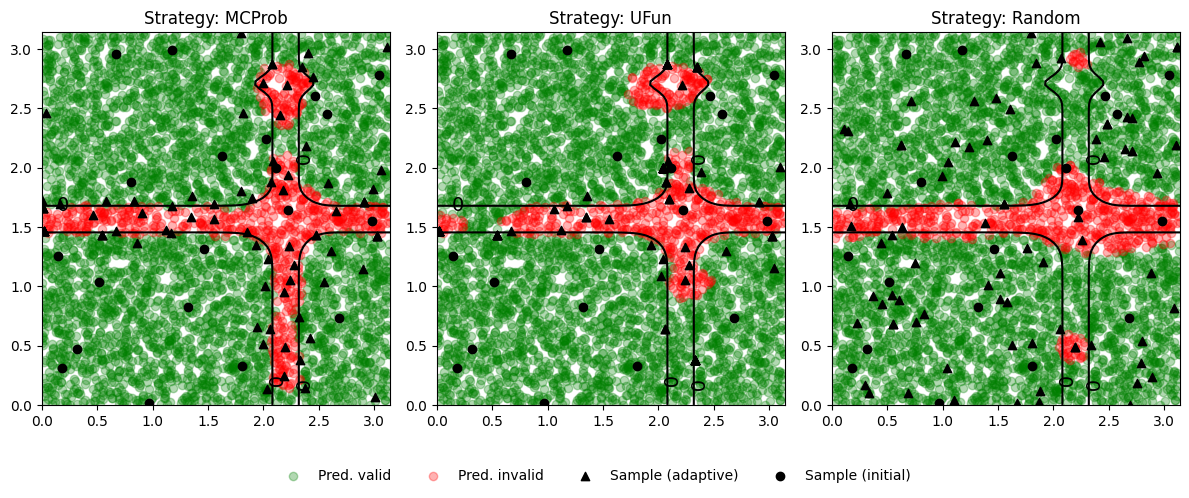

In [6]:
%matplotlib inline

if DIM == 2:
    # plot first trail
    trail = 0
    x1 = np.linspace(0, math.pi, 100)
    x2 = np.linspace(0, math.pi, 100)
    x1, x2 = np.meshgrid(x1, x2)
    X_mesh = np.c_[x1.ravel(), x2.ravel()]
    Y_test = tolerance - michalewicz.evaluate_true(torch.from_numpy(X_mesh)).abs()
    Y_test = Y_test.reshape(x1.shape)
    
    names = ["MCProb", "UFun", "Random"]
    preds = [
        prediction_last_mcp[trail]["prediction"].squeeze(), 
        prediction_last_ufun[trail]["prediction"].squeeze(), 
        prediction_last_rnd[trail]["prediction"].squeeze(),
    ]
    train_x_data = [
        prediction_last_mcp[trail]["x"].squeeze(), 
        prediction_last_ufun[trail]["x"].squeeze(), 
        prediction_last_rnd[trail]["x"].squeeze(),
    ]

    fig, axs = plt.subplots(ncols=len(names), figsize=(12, 5))

    for i, ax in enumerate(axs):
        cs = ax.contour(x1, x2, Y_test, [0], colors="k")
        ax.clabel(cs, fontsize=14, inline=False)
        pred = preds[i]
        ax.scatter(test_X[pred, 0], test_X[pred, 1], color="g", alpha=0.3, label="Pred. valid")
        ax.scatter(test_X[~pred, 0], test_X[~pred, 1], color="r", alpha=0.3, label="Pred. invalid")
        observed_x = train_x_data[i]
        ax.scatter(
            observed_x[N_init:, 0],
            observed_x[N_init:, 1],
            color="k",
            marker="^",
            label="Sample (adaptive)",
        )
        ax.scatter(
            observed_x[:N_init, 0],
            observed_x[:N_init, 1],
            color="k",
            marker="o",
            label="Sample (initial)",
        )
        ax.set_title(f"Strategy: {names[i]}")
    
    lines, labels = axs[0].get_legend_handles_labels()
    legend = fig.legend(
        lines,
        labels,
        loc="lower center",
        bbox_to_anchor=(0.5, 0.0),
        ncol=10,
        frameon=False,
    )
    plt.tight_layout()
    fig.subplots_adjust(bottom=0.18)
    plt.show()

### Plot Scores
We evaluate the results similar to a classification task. Therefore, we plot the F1-Score over the number of adaptive samples.

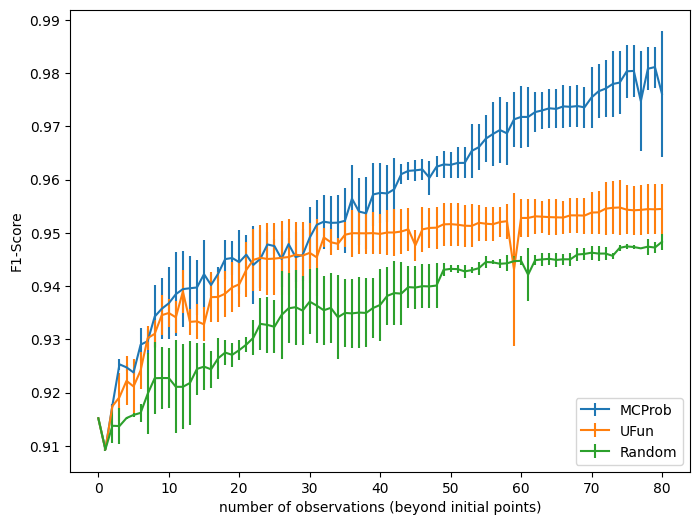

In [7]:
def ci(y):
    return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)


iters = np.arange(N_Samples + 1) * BATCH_SIZE
y_scores_mcp = np.asarray(scores_all_mcp)
y_scores_ufun = np.asarray(scores_all_ufun)
y_scores_rnd = np.asarray(scores_all_rnd)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.errorbar(
    iters,
    y_scores_mcp.mean(axis=0),
    yerr=ci(y_scores_mcp),
    label="MCProb",
    linewidth=1.5,
)
ax.errorbar(
    iters,
    y_scores_ufun.mean(axis=0),
    yerr=ci(y_scores_ufun),
    label="UFun",
    linewidth=1.5,
)
ax.errorbar(
    iters,
    y_scores_rnd.mean(axis=0),
    yerr=ci(y_scores_rnd),
    label="Random",
    linewidth=1.5,
)

ax.set(
    xlabel="number of observations (beyond initial points)",
    ylabel="F1-Score",
)
ax.legend(loc="lower right")
plt.show()